# Customer Churn Prediction Using Machine Learning

# Import Required Libraries

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, roc_auc_score
)

# Settings
sns.set(style="whitegrid")


# Load dataset (replace path if needed)

In [2]:
df = pd.read_csv("customer_churn_ml.csv")

# Preview data
df.head()


,customer_id,age,gender,tenure_months,monthly_charges,total_charges,contract_type,payment_method,internet_service,support_tickets,churn,lifetime_value
0,1,45,Male,12,70.5,846,Month-to-month,Credit Card,Fiber,3,1,1200
1,2,34,Female,48,55.2,2649,Two year,Bank Transfer,DSL,0,0,6800
2,3,29,Female,5,89.1,445,Month-to-month,Electronic Check,Fiber,5,1,900
3,4,62,Male,72,40.3,2901,Two year,Credit Card,NaN,1,0,8200
4,5,51,Female,24,65.0,1560,One year,Debit Card,DSL,2,0,4100


# Initial Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       200 non-null    int64  
 1   age               200 non-null    int64  
 2   gender            200 non-null    object 
 3   tenure_months     200 non-null    int64  
 4   monthly_charges   200 non-null    float64
 5   total_charges     200 non-null    int64  
 6   contract_type     200 non-null    object 
 7   payment_method    200 non-null    object 
 8   internet_service  144 non-null    object 
 9   support_tickets   200 non-null    int64  
 10  churn             200 non-null    int64  
 11  lifetime_value    200 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 18.9+ KB


In [4]:
df.describe(include="all")

,customer_id,age,gender,tenure_months,monthly_charges,total_charges,contract_type,payment_method,internet_service,support_tickets,churn,lifetime_value
count,200.000000,200.000000,200,200.000000,200.000000,200.000000,200,200,144,200.000000,200.000000,200.000000
unique,NaN,NaN,2,NaN,NaN,NaN,3,6,4,NaN,NaN,NaN
top,NaN,NaN,Male,NaN,NaN,NaN,Month-to-month,Electronic Check,Fiber,NaN,NaN,NaN
freq,NaN,NaN,101,NaN,NaN,NaN,77,63,94,NaN,NaN,NaN
mean,100.500000,44.325000,NaN,32.475000,67.389000,1687.645000,NaN,NaN,NaN,2.340000,0.385000,4333.600000
std,57.879185,11.957184,NaN,25.591876,20.507392,982.520724,NaN,NaN,NaN,2.079911,0.487816,2875.820711
min,1.000000,24.000000,NaN,1.000000,38.600000,98.000000,NaN,NaN,NaN,0.000000,0.000000,500.000000
25%,50.750000,34.000000,NaN,10.000000,45.050000,761.750000,NaN,NaN,NaN,1.000000,0.000000,1350.000000
50%,100.500000,44.000000,NaN,25.000000,67.350000,1692.000000,NaN,NaN,NaN,2.000000,0.000000,4325.000000
75%,150.250000,55.000000,NaN,60.000000,85.425000,2688.000000,NaN,NaN,NaN,4.000000,1.000000,7525.000000


# Check Missing Values

In [5]:
df.isnull().sum()

customer_id          0
age                  0
gender               0
tenure_months        0
monthly_charges      0
total_charges        0
contract_type        0
payment_method       0
internet_service    56
support_tickets      0
churn                0
lifetime_value       0
dtype: int64

# Feature Engineering

In [ ]:
# Create Average Monthly Spend Ratio
df["avg_monthly_spend_ratio"] = df["total_charges"] / (df["tenure_months"] + 1)

# High support usage flag
df["high_support_usage"] = (df["support_tickets"] >= 3).astype(int)

df.head()

,customer_id,age,gender,tenure_months,monthly_charges,total_charges,contract_type,payment_method,internet_service,support_tickets,churn,lifetime_value,avg_monthly_spend_ratio,high_support_usage
0,1,45,Male,12,70.5,846,Month-to-month,Credit Card,Fiber,3,1,1200,65.076923,1
1,2,34,Female,48,55.2,2649,Two year,Bank Transfer,DSL,0,0,6800,54.061224,0
2,3,29,Female,5,89.1,445,Month-to-month,Electronic Check,Fiber,5,1,900,74.166667,1
3,4,62,Male,72,40.3,2901,Two year,Credit Card,NaN,1,0,8200,39.739726,0
4,5,51,Female,24,65.0,1560,One year,Debit Card,DSL,2,0,4100,62.400000,0


# Define Features and Target Variable

In [8]:
X = df.drop(columns=["churn", "customer_id"])
y = df["churn"]

# Build Preprocessing Pipelines

In [9]:
#Categorical Pipeline (Imputation + One-Hot Encoding)
categorical_features = X.select_dtypes(include=["object"]).columns

#Numerical Pipeline (Imputation + Scaling)
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns

categorical_features, numerical_features


(Index(['gender', 'contract_type', 'payment_method', 'internet_service'], dtype='object'),
 Index(['age', 'tenure_months', 'monthly_charges', 'total_charges',
        'support_tickets', 'lifetime_value', 'avg_monthly_spend_ratio',
        'high_support_usage'],
       dtype='object'))

# Combine Transformers Using ColumnTransformer

In [10]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# Train–Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Baseline Model – Logistic Regression

In [13]:
baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

baseline_model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

# Evaluate Baseline Model

In [14]:
y_pred_base = baseline_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("F1 Score:", f1_score(y_test, y_pred_base))


Accuracy: 1.0
F1 Score: 1.0


# Random Forest Model

In [ ]:
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest F1:", f1_score(y_test, y_pred_rf))


Random Forest Accuracy: 1.0
Random Forest F1: 1.0


# XGBoost Model

In [16]:
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost F1:", f1_score(y_test, y_pred_xgb))


XGBoost Accuracy: 1.0
XGBoost F1: 1.0


# Cross-Validation Comparison

In [17]:
models = {
    "Logistic Regression": baseline_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

for name, model in models.items():
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5, scoring="f1"
    )
    print(f"{name} CV F1: {scores.mean():.4f}")


Logistic Regression CV F1: 1.0000
Random Forest CV F1: 1.0000
XGBoost CV F1: 1.0000


# Confusion Matrix Visualization

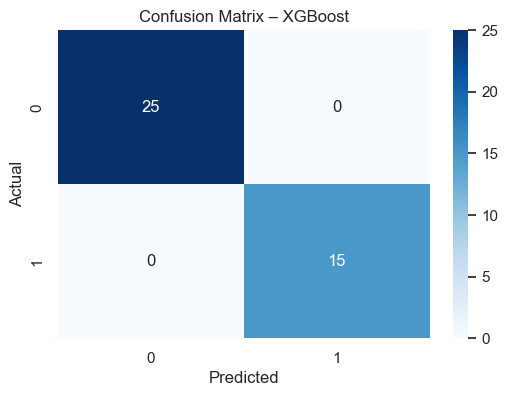

In [18]:
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost")
plt.show()


# Feature Importance Extraction

In [19]:
feature_names = (
    numerical_features.tolist() +
    list(xgb_model.named_steps["preprocessor"]
         .named_transformers_["cat"]
         .named_steps["onehot"]
         .get_feature_names_out(categorical_features))
)

importances = xgb_model.named_steps["classifier"].feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(15)


,feature,importance
5,lifetime_value,0.374347
4,support_tickets,0.231206
2,monthly_charges,0.229890
7,high_support_usage,0.104857
1,tenure_months,0.047911
3,total_charges,0.011789
0,age,0.000000
6,avg_monthly_spend_ratio,0.000000
8,gender_Female,0.000000
9,gender_Male,0.000000


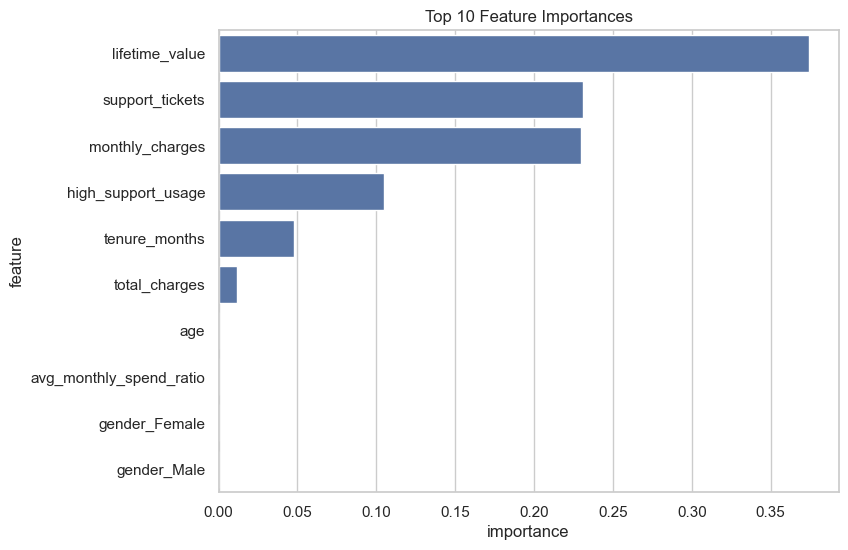

In [20]:
plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp.head(10), x="importance", y="feature")
plt.title("Top 10 Feature Importances")
plt.show()


## Key Insights
- Contract type and tenure strongly influence churn.
- High support ticket volume is a major churn indicator.
- Month-to-month contracts have significantly higher churn risk.

## Recommendations
- Offer incentives for long-term contracts.
- Proactively engage customers with high support usage.
- Introduce loyalty benefits after 6–12 months of tenure.
